In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# block_size = 3 # context length: how many characters do we take to predict the next one?
# X, Y = [], []
# for w in words:
  
#   #print(w)
#   context = [0] * block_size
#   for ch in w + '.':
#     ix = stoi[ch]
#     X.append(context)
#     Y.append(ix)
#     #print(''.join(itos[i] for i in context), '--->', itos[ix])
#     context = context[1:] + [ix] # crop and append

# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [7]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

    #print(w)
        context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([7, 3]) torch.Size([7])
torch.Size([6, 3]) torch.Size([6])
torch.Size([7, 3]) torch.Size([7])


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

NameError: name 'X' is not defined

In [9]:
C = torch.randn((27,2))

In [10]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C 

tensor([-1.0335,  0.2739])

In [11]:
Xtr.shape, Ytr.shape

(torch.Size([7, 3]), torch.Size([7]))

In [12]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [13]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [14]:
for p in parameters:
    p.requires_grad = True

In [15]:
lre = torch.linspace(-3 ,0, 1000)
lrs = 10**lre
#lrs

In [16]:
lri = []
lossi = []
stepi = []

In [17]:
C.shape

torch.Size([27, 10])

In [23]:
for i in range(200000):
    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    
    lr = 0.1 if i < 100000 else 0.01
        
    for p in parameters:
        p.data -= lr * p.grad
    
    #track stats
#     lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)



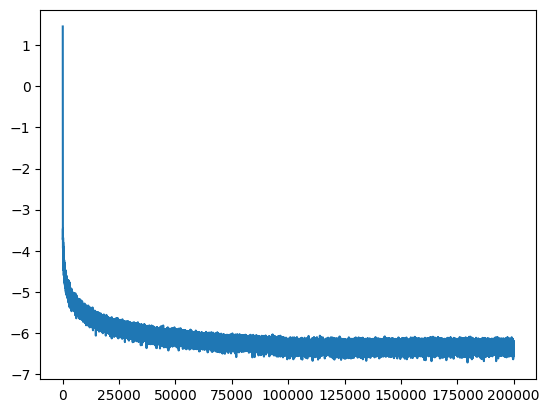

In [19]:
plt.plot(stepi, lossi)

In [20]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(28.6753, grad_fn=<NllLossBackward0>)

In [21]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(4.7684e-07, grad_fn=<NllLossBackward0>)

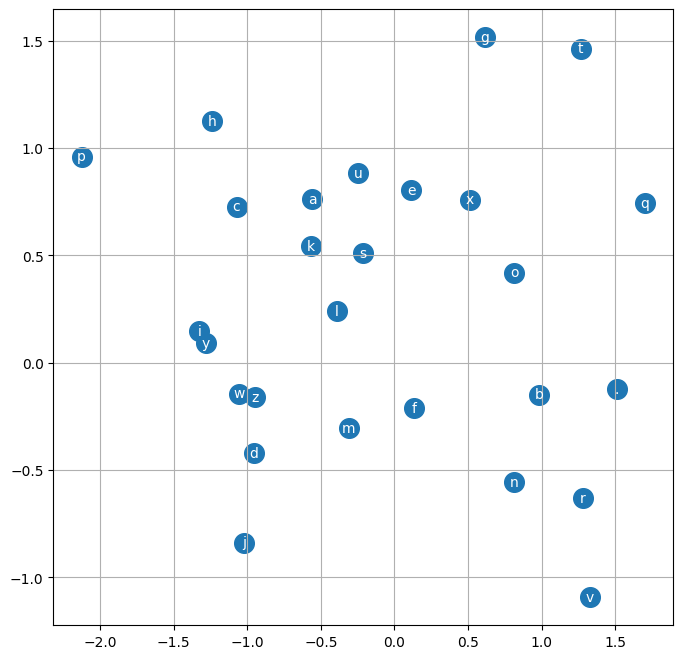

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [197]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amoriq.
khirgri.
reh.
cassanden.
jazonen.
den.
art.
kaqui.
nerania.
chaiir.
kaleig.
halma.
kinderian.
shon.
marianni.
wazelo.
dearynix.
kaelynnsa.
med.
